In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import public modules
import torch
import tqdm
import matplotlib
import numpy as np
from pathlib import Path

# Import custom modules
from applications.illustration.src import utils
from applications.illustration.src import models
from applications.illustration.src import plotting

# Use latex-like font for figures
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Generate the figures directory if it does not exist yet
figures_dir_path = './figures/'
utils.create_folder_if_inexistent(figures_dir_path)

# Define global device
_DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

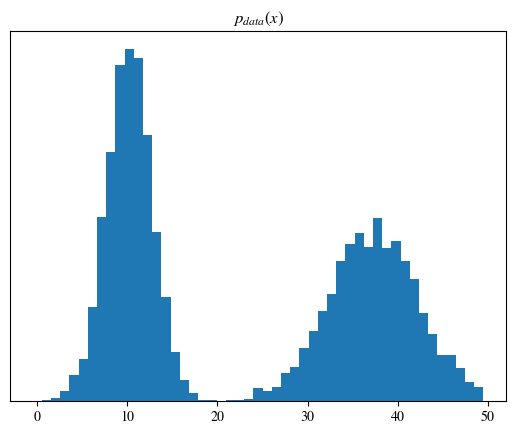

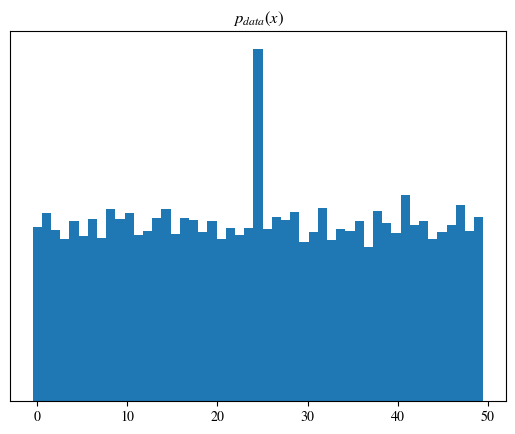

100%|██████████| 200/200 [00:18<00:00, 10.68it/s]


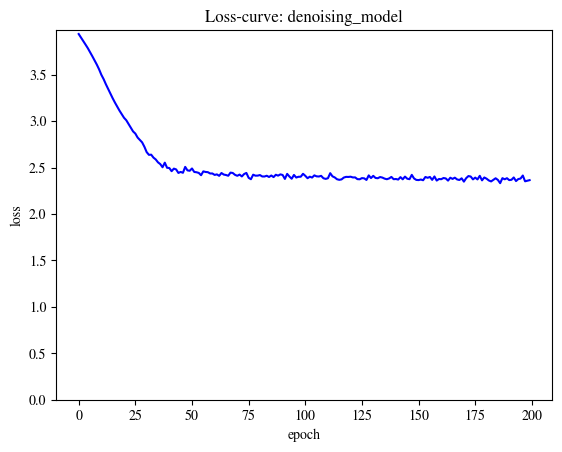

100%|██████████| 200/200 [00:17<00:00, 11.54it/s]


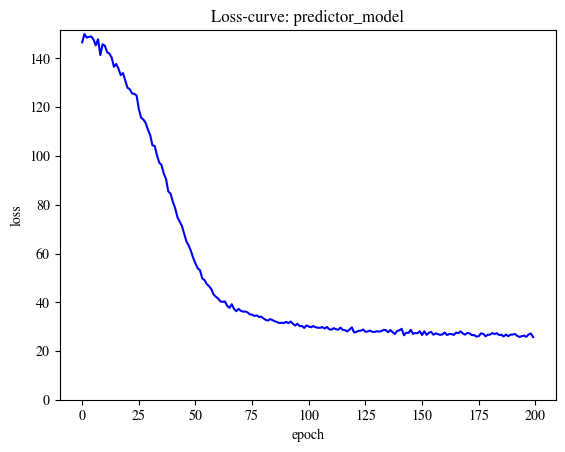

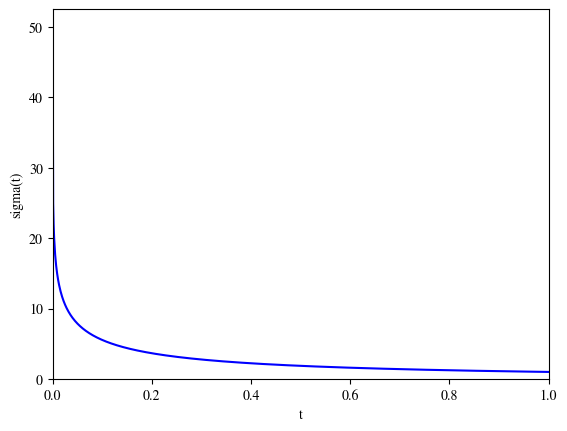

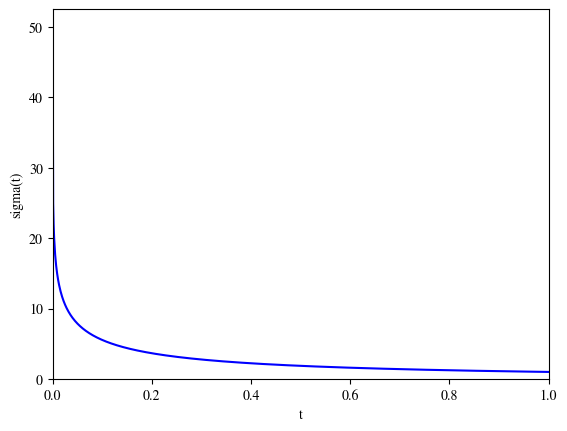

In [3]:
####################################
### Setup a toy dataset (D=1)
####################################
# Data specifications
num_data_pnts = 10000 # Number of datapoints
_S            = 50    # Number of states

# Define p_data categorical probabilities
mu_1 = _S*1/5
mu_2 = _S*3/4
sigma_1 = 0.05*_S
sigma_2 = 0.1*_S
p_data_list = utils.generate_p_data_cat_probs(mu_1, mu_2, sigma_1, sigma_2, S=_S)

# Generate the toy dataset
x_data, y_data = utils.generate_toy_dataset(num_data_pnts, p_data_list, seed=22)
plotting.plot_x_distribution(x_data, S=_S, title=r'$p_{data}(x)$')

# Setup a training set and define a dataloader
train_dataset = utils.DictDataset(x=torch.tensor(x_data, dtype=torch.long), 
                                  y=torch.tensor(y_data, dtype=torch.long),
                                  device=_DEVICE)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=len(train_dataset), # Use only 1 batch containing all the datapoints here 
                                               shuffle=True, 
                                               num_workers=0)

# Generate the toy dataset for the predictor
p_data_predictor = np.ones(_S)
p_data_predictor /= np.sum(p_data_predictor).squeeze()
p_data_list_predictor = [p_data_predictor]
x_data_predictor, y_data_predictor = utils.generate_toy_dataset(num_data_pnts, p_data_list_predictor, seed=22)
plotting.plot_x_distribution(x_data_predictor, S=_S, title=r'$p_{data}(x)$')

# Setup a training set and define a dataloader
train_dataset_predictor = utils.DictDataset(x=torch.tensor(x_data_predictor, dtype=torch.long), 
                                            y=torch.tensor(y_data_predictor, dtype=torch.long),
                                            device=_DEVICE)

train_dataloader_predictor = torch.utils.data.DataLoader(train_dataset_predictor, 
                                                         batch_size=len(train_dataset_predictor), # Use only 1 batch containing all the datapoints here 
                                                         shuffle=True, 
                                                         num_workers=0)

# Define models
models_dict = dict()
optims_dict = dict()

utils.set_random_seed(15)
models_dict['denoising_model'] = models.DenoisingModel(D=1, S=_S, hidden_dims=[100]).to(_DEVICE)
optims_dict['denoising_model'] = torch.optim.Adam(models_dict['denoising_model'].parameters(), lr=0.005)

utils.set_random_seed(15)
models_dict['predictor_model'] = models.PredictorModel(y_guide_name='y', D=1, S=_S, sigma_noised=_S, sigma_unnoised=1, hidden_dims=[100]).to(_DEVICE)
optims_dict['predictor_model'] = torch.optim.Adam(models_dict['predictor_model'].parameters(), lr=0.005)


# Train both models
utils.train_model('denoising_model', num_epochs=200, S=_S, models_dict=models_dict, optims_dict=optims_dict, dataloader=train_dataloader)
utils.train_model('predictor_model', num_epochs=200, S=_S, models_dict=models_dict, optims_dict=optims_dict, dataloader=train_dataloader_predictor)
models_dict['predictor_model'].plot_sigma_t(_DEVICE)


In [4]:
### Generate and create a dictionary for results
generation_dict_dict = dict()

# Set global settings
num_samples = 100000
dt          = 0.001
noise       = 0
y_guide     = 30
guide_temp  = 20

######################################################################
### UNCONDITIONAL
######################################################################
print('Unconditional:')
# Generate and cast resulting x_t from tensors to numpy arrays
print(f"Generate {num_samples} trajectories:")
x_t_list, t_list = utils.generate(models_dict, 
                                               B=num_samples, 
                                               S=_S, 
                                               D=1, 
                                               seed=42, 
                                               x1_temp=1.0, 
                                               noise=noise, 
                                               dt=dt,
                                               y_guide=None, # NO GUIDANCE/UNCONDITIONAL SAMPLING
                                               device=_DEVICE)

print(f"Generation Done.")
print()

# Postprocess
print(f"Postprocess generated samples")
postprocessing_dict = plotting.generation_postprocessing(t_list, x_t_list, S=_S)
print(f"Postprocessing done")

# Add to genration dictionary
generation_dict_dict['unconditional'] = {
    't_list': t_list,
    'x_t_list': x_t_list,
    'postprocessing_dict': postprocessing_dict,
}

print('-'*100)

######################################################################
### GUIDED
######################################################################
print('Guided:')
# Generate and cast resulting x_t from tensors to numpy arrays
print(f"Generate {num_samples} trajectories:")
x_t_list, t_list = utils.generate(models_dict, 
                                               B=num_samples, 
                                               S=_S, 
                                               D=1, 
                                               seed=42, 
                                               x1_temp=1.0, 
                                               noise=noise, 
                                               dt=dt,
                                               guide_temp=guide_temp,
                                               y_guide=y_guide, # GUIDANCE/CONDITIONAL SAMPLING
                                               device=_DEVICE)

print(f"Generation Done.")
print()

# Postprocess
print(f"Postprocess generated samples")
postprocessing_dict = plotting.generation_postprocessing(t_list, x_t_list, S=_S)
print(f"Postprocessing done")

# Add to genration dictionary
generation_dict_dict['guided'] = {
    't_list': t_list,
    'x_t_list': x_t_list,
    'postprocessing_dict': postprocessing_dict,
}


######################################################################
### PREDICTOR
######################################################################
# Visualize the predictor on noisy samples
_x = np.linspace(0, _S-1, _S)
batch_data = {
    'x': torch.tensor(_x, dtype=torch.long).to(_DEVICE).view(-1, 1),
    'y': y_guide*torch.ones(_S).to(_DEVICE),
}

# Set model into evaluation mode
models_dict['predictor_model'].eval()

probs_list = list()
num_time_steps = int(1/dt)+1
t_values = np.linspace(0, 1, num_time_steps)
print(f"Evaluate predictor")
for t_value in tqdm.tqdm(t_values):
    t = t_value*torch.ones(_S).to(_DEVICE)
    log_prob = models_dict['predictor_model'].log_prob(batch_data, t)
    probs = utils.to_numpy(torch.exp(log_prob))
    probs_list.append(probs)

generation_dict_dict['predictor'] = {
    'predictor_probs_matrix': np.vstack(probs_list),
    'postprocessing_dict': postprocessing_dict, 
}
print(f"Evaluation done")



Unconditional:
Generate 100000 trajectories:


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 555.40it/s]


Generation Done.

Postprocess generated samples
Postprocessing done
----------------------------------------------------------------------------------------------------
Guided:
Generate 100000 trajectories:


100%|██████████| 1000/1000 [00:41<00:00, 24.02it/s]


Generation Done.

Postprocess generated samples
Postprocessing done
Evaluate predictor


100%|██████████| 1001/1001 [00:00<00:00, 2328.14it/s]

Evaluation done


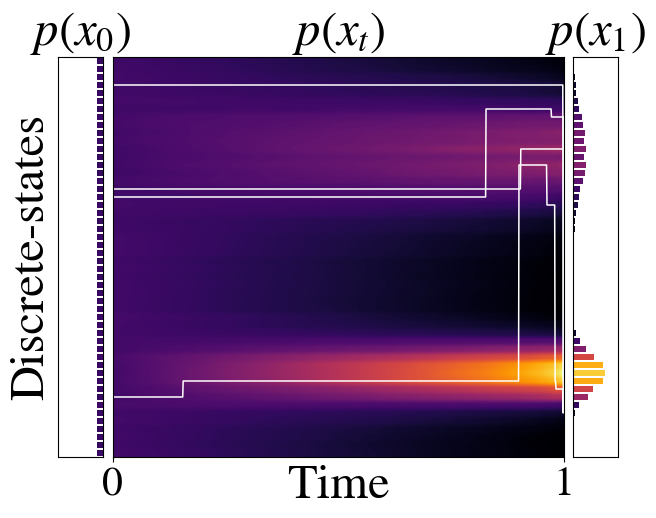

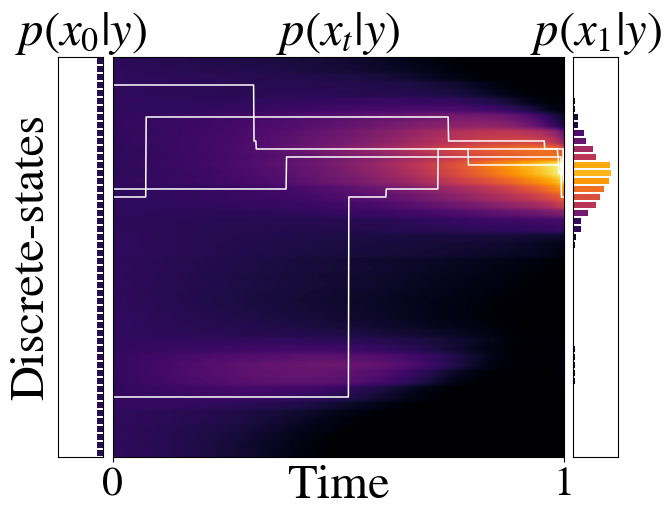

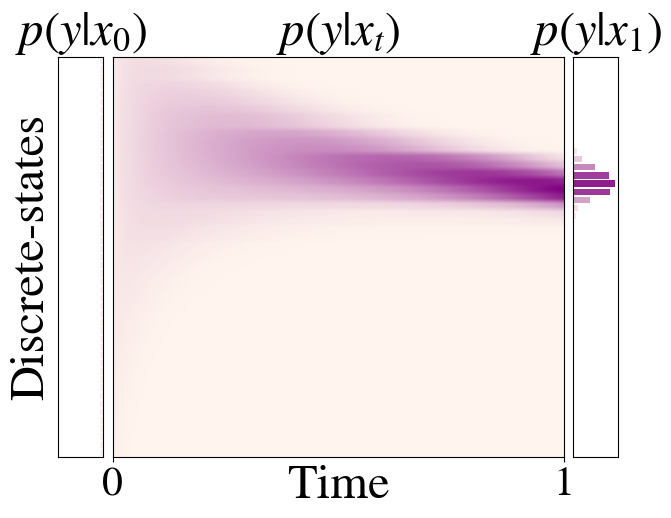

In [5]:
# Set general plots specs
custom_cmap = plotting.custom_cmap(color_start='seashell', color_end='purple')
plot_specs = {
    'figsize': (7, 5),
    'sp_width_ratios': [1, 10, 1],
    'title_fs': 35,
    'axis_fs': 35,
    'tick_fs': 30,
    'axis_label_pad': -28,
    'cmap': {'generative': 'inferno', 'predictor': custom_cmap},
    'hist_background_color': 'white', #'ghostwhite',
    'trajectories_color': 'w',
    'trajectories_lw': 1.1, #0.35,
    'num_trajectories': 4,
    'color_dampening': 0.875,
    'max_scaling': {'generative': 7.0, 'predictor': 13.0},
}

fig1 = plotting.make_time_evolution_plot(generation_dict_dict['unconditional'], plot_specs, conditional=False, figpath=Path(figures_dir_path, 'evolution1.pdf'))
fig2 = plotting.make_time_evolution_plot(generation_dict_dict['guided'], plot_specs, conditional=True,         figpath=Path(figures_dir_path, 'evolution2.pdf'))
fig3 = plotting.make_time_evolution_plot_predictor(generation_dict_dict['predictor'], plot_specs,              figpath=Path(figures_dir_path, 'evolution3.pdf'))

